## Deepar

In [6]:
import json
from gluonts.dataset.common import ListDataset
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
import matplotlib.pyplot as plt
from itertools import islice
from gluonts.evaluation import Evaluator
import pandas as pd
import torch
torch.set_float32_matmul_precision('high')

In [30]:
# Load JSONL into a list of dicts
with open("../data/processed/deepar_dataset.jsonl") as f:
    series_list = [json.loads(line) for line in f]


In [31]:
#subset 100 data points
s = series_list[0]
dataset = ListDataset(series_list, freq="5min")


In [32]:
estimator = DeepAREstimator(
    prediction_length=288,
    context_length=288,
    freq="5min",
    hidden_size=120,
    num_layers=4,
    dropout_rate=0.1,
    lr=1e-3,
    weight_decay=1e-8,
    batch_size=128,
    num_batches_per_epoch= int(len(series_list[0]['target']) / 128),  
    trainer_kwargs={
        "max_epochs": 50,
        "accelerator": "auto",
        "precision": "16-mixed",  
        "gradient_clip_val": 10.0,
        "logger": False,
    }
)

In [ ]:
predictor = estimator.train(dataset)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode  | In sizes                                                          | Out sizes    
----------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 428 K  | train | [[1, 1], [1, 1], [1, 1440, 6], [1, 1440], [1, 1440], [1, 288, 6]] | [1, 100, 288]
----------------------------------------------------------------------------------------------------------------------------------
428 K     Trainable params
0         Non-trainable params
428 K     Total params
1.712     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 0: |                                                                              | 47/? [01:16<00:00,  0.62it/s]

In [15]:
# Evaluate
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset,
    predictor=predictor,
    num_samples=100
)
forecast_list = list(forecast_it)
ts_list = list(ts_it)

In [16]:

# Evaluation
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(ts_list, forecast_list)

# Print summary
print("\nAggregate Metrics:")
for k, v in agg_metrics.items():
    print(f"{k:>20}: {v:.4f}")


Running evaluation: 5it [00:00, 18.23it/s]



Aggregate Metrics:
                 MSE: 1.4311
           abs_error: 1045.1602
      abs_target_sum: 2389.0000
     abs_target_mean: 1.6590
      seasonal_error: 0.8808
                MASE: 0.9508
                MAPE: 0.3061
               sMAPE: 0.3974
                MSIS: 12.4072
num_masked_target_values: 0.0000
   QuantileLoss[0.1]: 248.4927
       Coverage[0.1]: 0.0035
   QuantileLoss[0.2]: 469.2538
       Coverage[0.2]: 0.1472
   QuantileLoss[0.3]: 696.2949
       Coverage[0.3]: 0.2444
   QuantileLoss[0.4]: 901.0123
       Coverage[0.4]: 0.3778
   QuantileLoss[0.5]: 1045.1601
       Coverage[0.5]: 0.4049
   QuantileLoss[0.6]: 1161.5135
       Coverage[0.6]: 0.4333
   QuantileLoss[0.7]: 1225.4822
       Coverage[0.7]: 0.4590
   QuantileLoss[0.8]: 1221.7752
       Coverage[0.8]: 0.5292
   QuantileLoss[0.9]: 1108.9159
       Coverage[0.9]: 0.6611
                RMSE: 1.1963
               NRMSE: 0.7211
                  ND: 0.4375
  wQuantileLoss[0.1]: 0.1040
  wQuantileLoss[0.

/Users/xuximin/miniforge3/envs/satcast/lib/python3.12/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


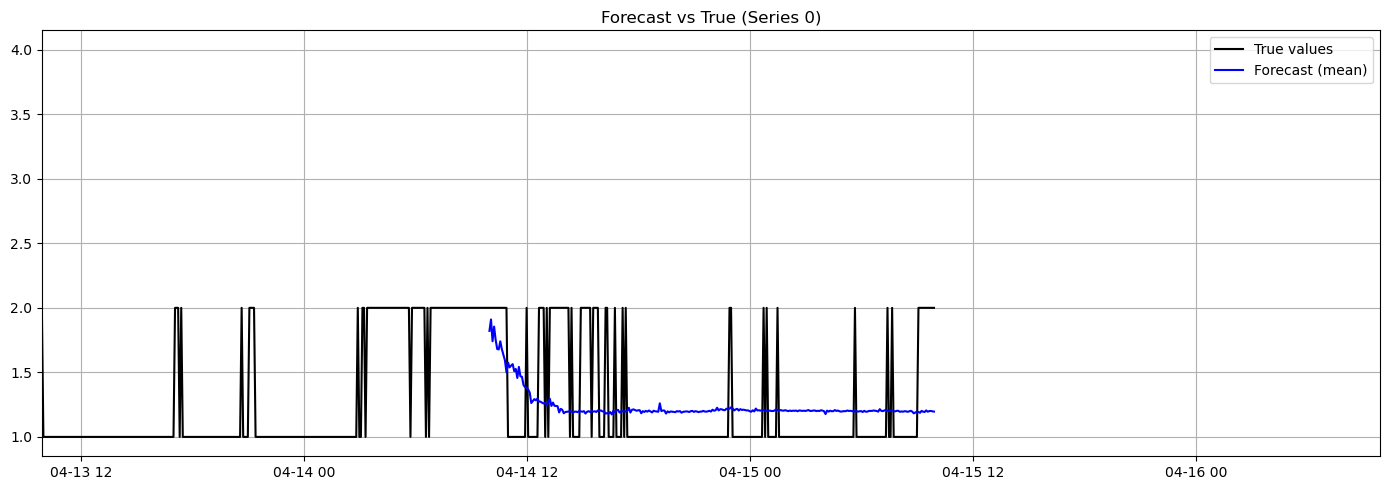

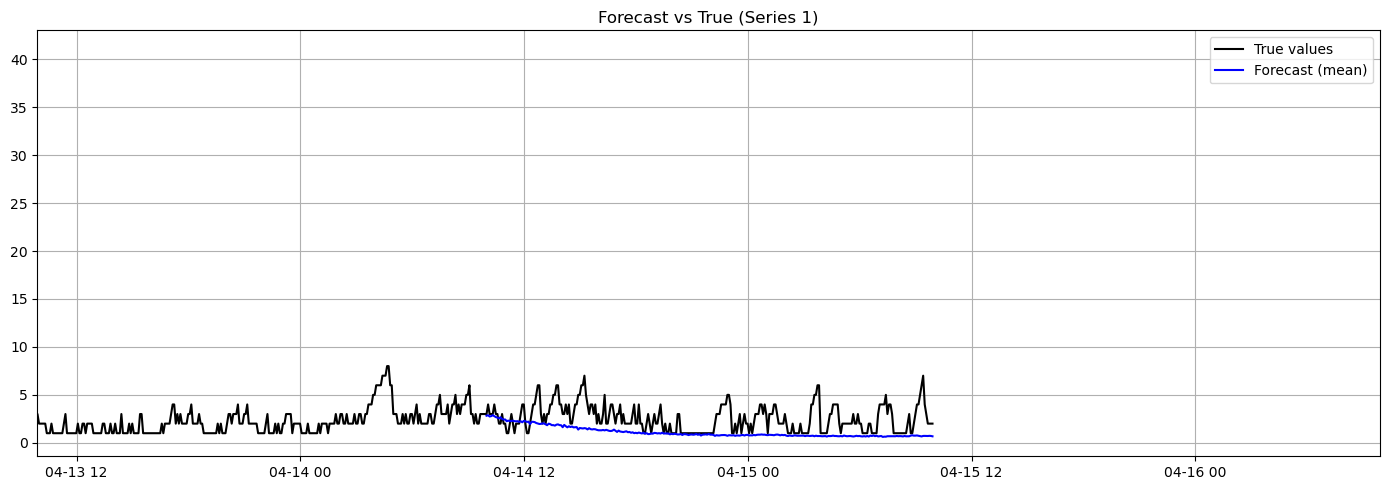

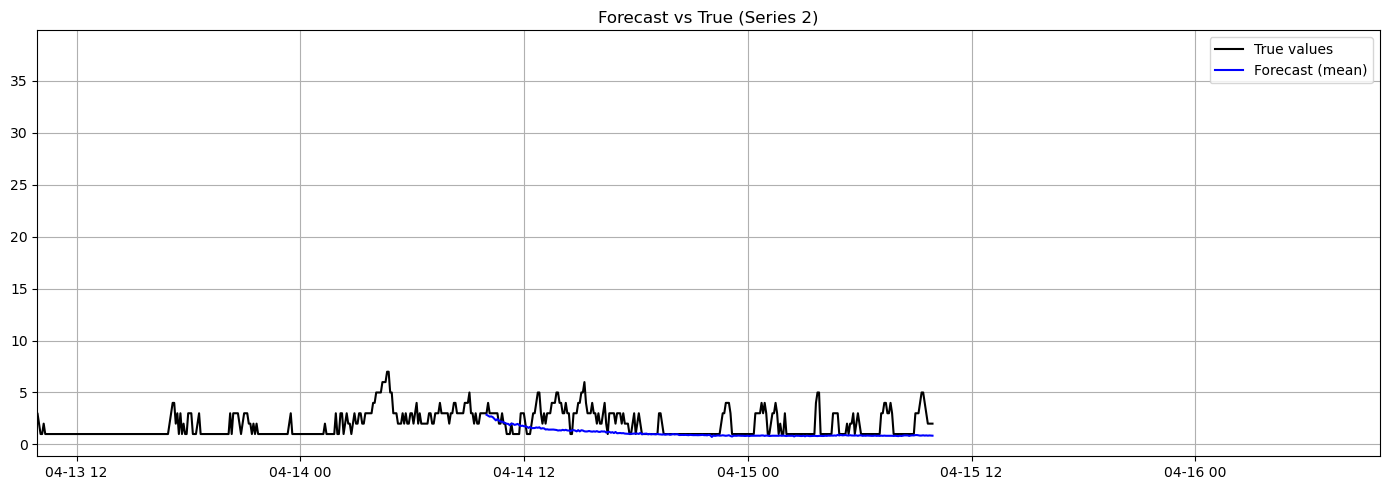

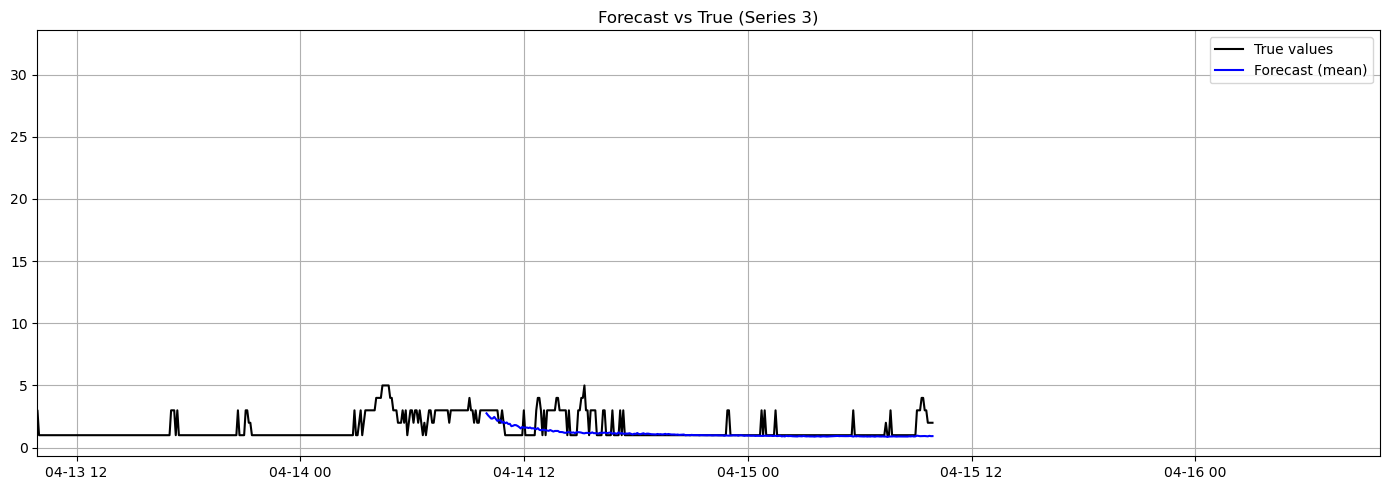

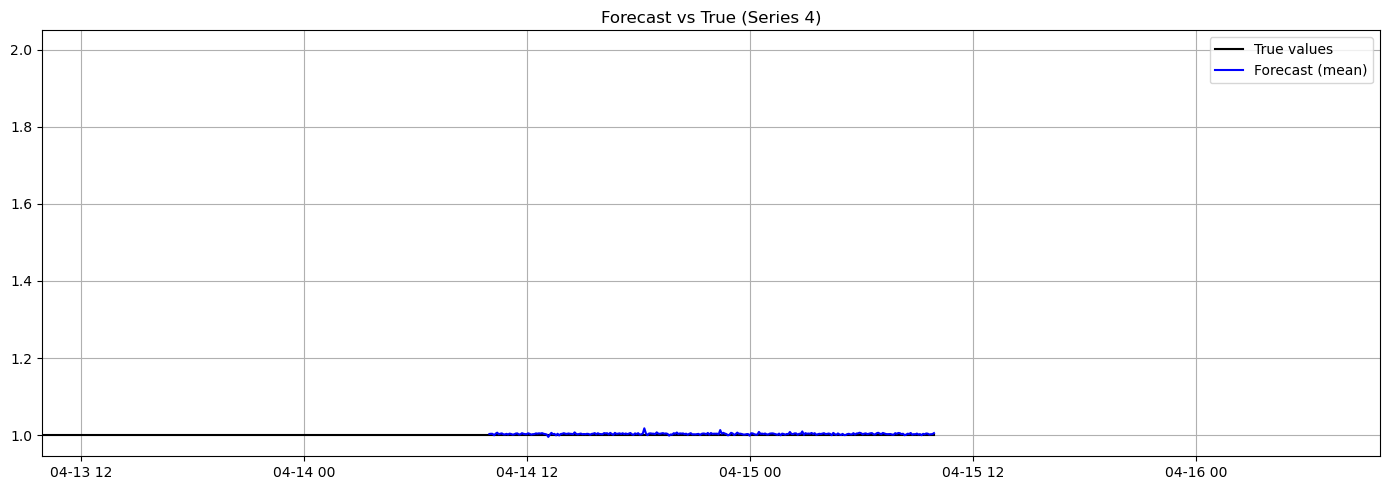

In [17]:
n_plots = len(forecast_list)  # or set a lower limit for visual clarity
for i in range(n_plots):
    ts = ts_list[i]
    forecast = forecast_list[i]

    # Convert PeriodIndex to Timestamp for plotting
    ts_index = ts.index.to_timestamp()

    # Forecast timestamps
    start = forecast.start_date.to_timestamp()
    freq = pd.Timedelta(forecast.freq)
    forecast_index = pd.date_range(start=start, periods=len(forecast.mean), freq=freq)

    # Determine x-axis limits (last 2 days)
    last_time = ts_index[-1]
    xlim_start = last_time - pd.Timedelta(days=2)
    xlim_end = last_time + pd.Timedelta(minutes=5 * len(forecast.mean))  # include forecast horizon

    # Plot
    plt.figure(figsize=(14, 5))
    plt.plot(ts_index, ts.values, label="True values", color="black")
    plt.plot(forecast_index, forecast.mean, label="Forecast (mean)", color="blue")

    plt.title(f"Forecast vs True (Series {i})")
    plt.legend()
    plt.grid(True)
    plt.xlim(xlim_start, xlim_end)
    plt.tight_layout()
    plt.show()
